# Kaggle: House Prices Advanced Regression Techniques

#### Copmetition Specification:
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

#### Approach:
* Feature creation using pandas
* Create pipeline to manage preprocessing (transformation) and stacking (model)

#### Objective is to demonstrate:
* regression techniques
* feature creation
* manual outlier removal
* sklearn pipelines for transformation of data and model training
* category encoders for encoding methods
* imbalanced learn for outlier detection and removal (not yet implemented)
* scikit optimization for parameter tuning
* mlxtend for model stacking
* cross-validation



##### Limitations:
* no eda: there are many other notebooks for this competition with in depth eda

##### Further Enhancements:
* feature engineering and outlier removal made the largest impact on the model
* automated outlier detection, rather than handpick, and include in pipeline using imblearn pipelines
* method for detecting bad leverage points
* further feature engineering
* add more tuned models

## Resources

* skLearn pipeelines (introduction): https://www.kaggle.com/dansbecker/pipelines
* skLearn pipelines (tutorial): https://www.kaggle.com/aashita/advanced-pipelines-tutorial
* skLearn pipelines (examples): https://www.codementor.io/bruce3557/beautiful-machine-learning-pipeline-with-scikit-learn-uiqapbxuj
* skLearn pipelines (custom transformers - for feature creation): https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

* Feature encoding: https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159
* Feature ecnoding cheat sheet: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

* preporcessing steps: https://hackernoon.com/a-brief-overview-of-automatic-machine-learning-solutions-automl-2826c7807a2a

* Outliers vs leverage points: https://pdfs.semanticscholar.org/d648/592c98bc63164ac6f6989e1af5c525a06817.pdf
* Dealing wiht outliers sklearn: https://www.mikulskibartosz.name/outlier-detection-with-scikit-learn/
* normalising skewed data: https://www.quora.com/How-does-skewness-impact-regression-model
* feature transformations: https://medium.com/@sjacks/feature-transformation-21282d1a3215
* hyperparameter tuning using skopt: https://medium.com/@vincent.kr18/hyper-parameter-tuning-using-bayesian-optimisation-code-b50e0e8abe20
* ensemble: https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/



## Import Libraries

In [1]:
# kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

# file handling
import requests
import os
import zipfile

# data hnadling
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# classification models
from xgboost import XGBClassifier

# pre-processing
from sklearn.preprocessing import Imputer

# encoding methods
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# sklearn pipelines
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# metrics to assess classification models
from sklearn.metrics import precision_recall_fscore_support

# other imports
from pprint import pprint

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Get Data

Download data using Kaggle API

In [2]:
save_folder = "DataSets/"

# if save folder does not exist, create
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
# authenticate and download competition
api = KaggleApi()
api.authenticate()
competition = "house-prices-advanced-regression-techniques"
files = api.competition_download_files(competition, path = save_folder)

# unzip files and remove zip file
dataSet_folder = save_folder + competition

with zipfile.ZipFile(dataSet_folder + ".zip","r") as zip_ref:
    zip_ref.extractall(dataSet_folder)
    
os.remove(dataSet_folder + ".zip")

## Import Data

Import data from folder

In [3]:
dataSet_folder = save_folder + competition

train_csv = 'train.csv'
test_csv = 'test.csv'
sample_submission_csv = 'sample_submission.csv'

trainData = os.path.join(dataSet_folder, train_csv)
testData = os.path.join(dataSet_folder, test_csv)
sampleData = os.path.join(dataSet_folder, sample_submission_csv)

df_train = pd.read_csv(trainData)
df_test = pd.read_csv(testData)
df_sample_submission = pd.read_csv(sampleData)

In [4]:
test_rows = df_test.shape[0]

## Target

We aim to build a regressor to predict the home sale price.

In [241]:
# target variable
target = 'SalePrice'

## Evaluation Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

$$ L(y, \hat y) = \sqrt{  (1/N) \cdot \sum_{i=0}^N (\log(y_{i}+1) - \log(\hat y_{i}+1))^2 }$$

Use RMSLE when doing regression, believing that your target, conditioned on the input, is normally distributed, and you don’t want large errors to be significantly more penalized than small ones, in those cases where the range of the target value is large.

Note that, the RMSLE can not handle any predicted values which are less than zero (negative logs are not defined.) For ease we will log transform the target variable, and then inverse this operation before submission. This way we can use the RMSE and avoid any errors on negative predictions. We will be careful to monitor that there are no negative values being predicted as we develop the model and also use the RSMLE before any final submissions.

In [242]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

scoring_cross_val = 'neg_mean_squared_error'
scoring = mean_squared_error

# define function for root mean squared error (not defined in sklearn)
def RMSE(y_pred, y):
    rmse = mean_squared_error(y_pred, y)**(1/2)
    return rmse

# define function for cross validating root mean squared error (not defined in sklearn)
def cross_val_RMSE(model, X, y, cv, scoring="neg_mean_squared_error"):
    cv_rmse = cross_val_score(model, X, y, cv=cv, scoring = scoring)
    cv_rmse = (-cv_rmse.mean())**(1/2)
    return cv_rmse

# log transform the trget variable
df_train[target] = np.log1p(df_train[target])

## EDA

The purpose of this document is notebook is not to display skills in EDA. There are many very in depth EDA which have been performed for this competition. For example read:
* https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook

## PreProcessing

Any preprocessing steps which can not be contained with a sklearn pipeline are in the following section. Target over time is to move all steps into pipeline - other than perhaps feature creation which naturally sits in pandas.

##### Merge DataFrames
Merge so all preprocessing can be done on one dataFrame. DataFrames split after preprocessing.

In [243]:
df_test[target] = np.NaN
df_test['test_train'] = 'test'
df_train['test_train'] = 'train'
df_all = pd.concat([df_train.copy(), df_test.copy()], sort=True)
df_all.reset_index(drop=True, inplace=True)

##### Clean Column Headers

In [244]:
df_all.columns = map(str.lower, df_all.columns)
df_all.columns = df_all.columns.str.replace(' ', '_')
target = target.lower()

#### Outliers

Despite experimenting with outlier detection methods I could not find a better set of outliers than seen in other kernels for this competition. The ability to detect meaningful outliers alongside feature creation, has a large impact on the final results. This is an area to explore further.

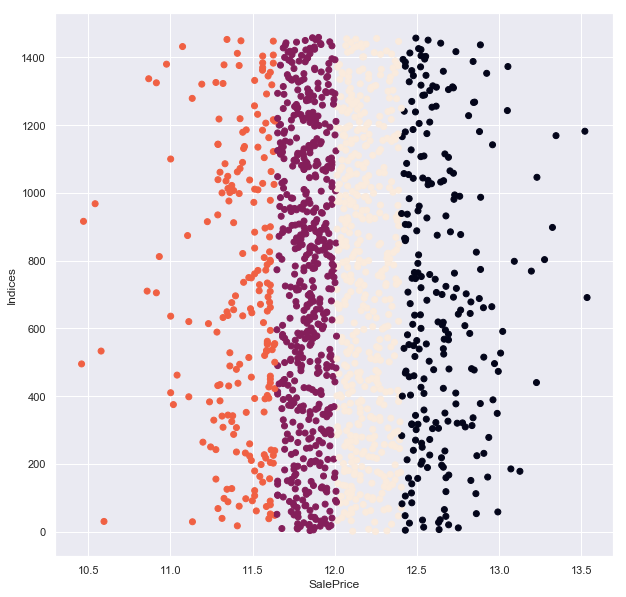

In [245]:
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq

data_raw = df_train['SalePrice'].to_numpy()
centroids, avg_distance = kmeans(data_raw, 4)
groups, cdist = vq(data_raw, centroids)

y = np.arange(0,df_train.shape[0])
plt.figure(figsize=(10,10))
plt.scatter(data_raw,  y , c=groups)
plt.xlabel('SalePrice')
plt.ylabel('Indices')
plt.show()

In [246]:
df_all = df_all[((df_all.grlivarea < 4500) & (df_all.test_train =='train')) | (df_all.test_train =='test')]
df_all.reset_index(drop=True, inplace=True)

outliers = [30, 88, 462, 631, 1322]
df_all = df_all.drop(df_all.index[outliers])


##### DataTypes

Inspecting each of the dataFraes created below manually, we can see that all the numerical data are cast as float and int and all categorical data is cast as object.


In [247]:
df_all_float = df_all.select_dtypes(include='float64',)
df_all_object = df_all.select_dtypes(include='object',)
df_all_int = df_all.select_dtypes(include='int64',)
df_all_bool = df_all.select_dtypes(include='bool',)
df_all_datetime64 = df_all.select_dtypes(include='datetime64',)
df_all_timedelt= df_all.select_dtypes(include='timedelta',)
df_all_category = df_all.select_dtypes(include='category',)

# check all columns accounted for
assert((set(df_all_float.columns).union(set(df_all_object.columns)).union(
    set(df_all_int.columns)).union(set(df_all_bool.columns)).union(
    set(df_all_datetime64.columns)).union(set(df_all_category.columns))) == set(df_all.columns))

##### Missing Values

Missing values will be processed in our pipeline. In this section we will simply look at which features have missing values and look into why.

<u>Object: </u>

We need to determine if the missing categorical data represents a category that is not relevant to that property or if it is genuinely missing which needs to be imputed.
* <b>Systematically Missing Values:</b>fireplacequ, alley, masvnrtype, fence, bsmtfintype1, bsmtqual, garagequal, garagefinish, exterior2nd, garagecond, bsmtexposure, poolqc, bsmtcond, mszoning, miscfeature, garagetype, bsmtfintype2
* <b>Randomly Missing Values:</b> electrical, exterior1st, functional, kitchenqual, mszoning, saletype, utilities

<u>Float: </u> 

We need to determine if there is a missing numerical data point because the feature in question is not relevant to that property or if it is genuinely missing data which needs to be imputed.
* <b>Systematically Missing Values:</b> bsmtfinsf1, bsmtfinsf2, bsmtfullbath, bsmthalfbath, bsmtunfsf, garagearea, garagecars, garageyrblt, masvnrarea, totalbsmtsf
* <b>Randomly Missing Values:</b> lotfrontage

<u>Int: </u>

We need to determine if there is a missing numerical data point because the feature in question is not relevant to that property or if it is genuinely missing data which needs to be imputed.
* <b>Systematically Missing Values:</b> none
* <b>Randomly Missing Values:</b> none

##### Recasting DateTime Values

In [248]:
import datetime as dt

#categorical_variables = list(df_all_object.columns)
datetime_variables = ['yearbuilt', 'yearremodadd', 'yrsold']

    
for dat_var in datetime_variables:
    # convert to date time / then back to ordinal for regression
    df_all[dat_var] = df_all[dat_var].astype('datetime64[ns]')
    df_all[dat_var] = df_all[dat_var].map(dt.datetime.toordinal)
    
# check all columns accounted for
assert((set(df_all_float.columns).union(set(df_all_object.columns)).union(
    set(df_all_int.columns)).union(set(df_all_bool.columns)).union(
    set(df_all_datetime64.columns)).union(set(df_all_category.columns))) == set(df_all.columns))

#### Feature Creation

In [249]:
## numerical
df_all['yearbuiltremod'] = df_all['yearbuilt'] + df_all['yearremodadd']
df_all['overallrating'] = df_all['overallqual'] + df_all['overallcond']
df_all['totalsf'] = df_all['totalbsmtsf'] + df_all['1stflrsf'] + df_all['2ndflrsf']
df_all['totalsquarefootage'] = df_all['bsmtfinsf1'] + df_all['bsmtfinsf2'] + df_all['1stflrsf'] + df_all['2ndflrsf']
df_all['totalbath'] = df_all['fullbath'] + (0.5 * df_all['halfbath']) + df_all['bsmtfullbath'] + (0.5 * df_all['bsmthalfbath'])
df_all['totalporchsf'] = df_all['openporchsf'] + df_all['3ssnporch'] + df_all['enclosedporch'] + df_all['screenporch'] + df_all['wooddecksf']

## categorical
# houses which contain certain features e.g. haspool if house has a pool
df_all['haspool'] = df_all['poolarea'].apply(lambda x: 1 if x > 0 else 0)
df_all['has2ndfloor'] = df_all['2ndflrsf'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasgarage'] = df_all['garagearea'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasbsmt'] = df_all['totalbsmtsf'].apply(lambda x: 1 if x > 0 else 0)
df_all['hasfireplace'] = df_all['fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# is new house, determined if year built is the same as year sold
df_all['newhouse'] = 0
idx = df_all[df_all['yrsold'] == df_all['yearbuilt']].index
df_all.loc[idx, 'newhouse'] = 1

In [250]:
assert(df_all[df_all['test_train']=='test'].shape[0] == test_rows)

##### Highly Skewed Features

This is an example of how the pipeline below deals with skewed variables. This is not applied to the dataFrame at this point.

/Users/IainMac/anaconda3/envs/portfolio_machinelearning/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


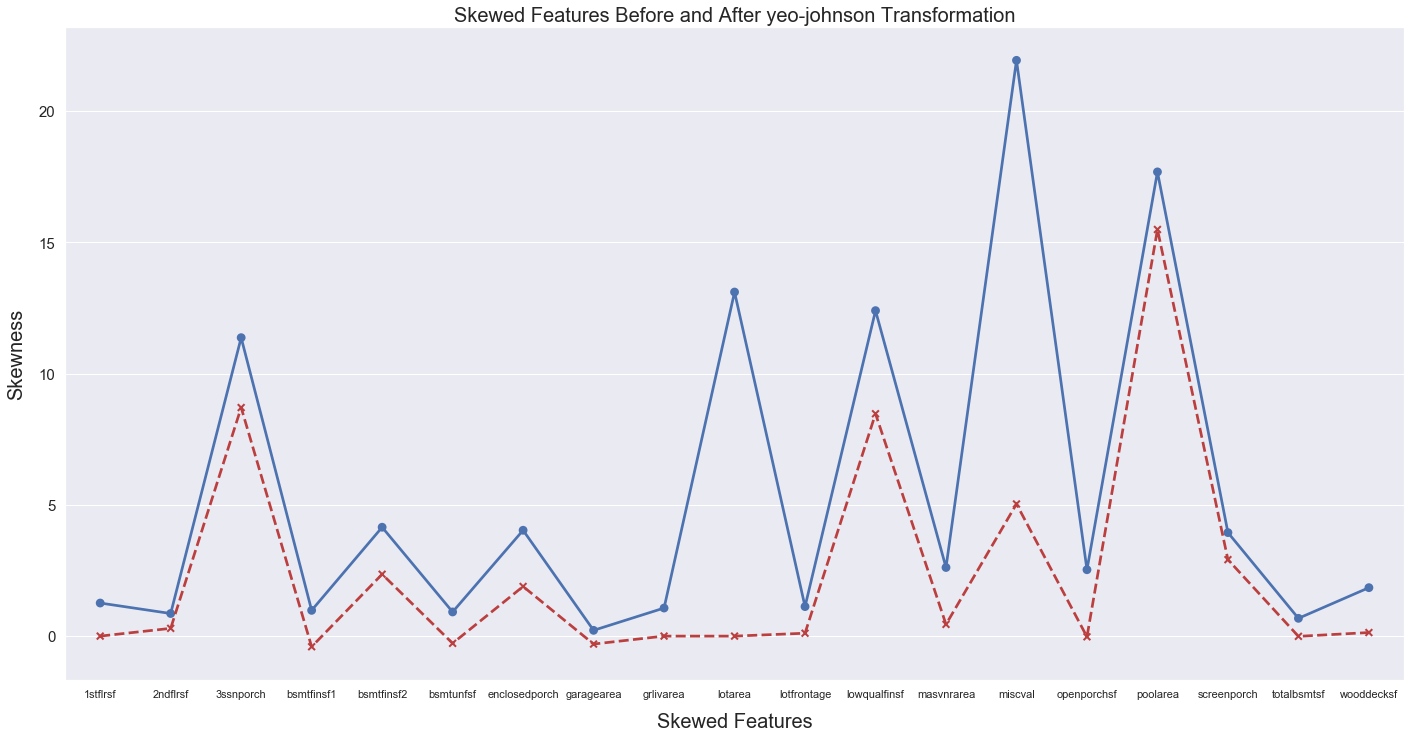

In [251]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, power_transform, PowerTransformer


df_example = df_all.copy()

cont_features = ['1stflrsf', '2ndflrsf', '3ssnporch', 'bsmtfinsf1', 'bsmtfinsf2',
                 'bsmtunfsf', 'enclosedporch', 'garagearea', 'grlivarea', 'lotarea', 
                 'lotfrontage', 'lowqualfinsf', 'masvnrarea', 'miscval', 'openporchsf', 
                 'poolarea', 'screenporch', 'totalbsmtsf', 'wooddecksf']

skewed_features = {feature: df_example[feature].skew() for feature in cont_features}

df_example[cont_features] = power_transform(df_example[cont_features], 'yeo-johnson')

transformed_skews = {feature: df_example[feature].skew() for feature in cont_features}

df_skew = pd.DataFrame(index=skewed_features.keys(), columns=['Skew', 'Skew after boxcox1p'])
df_skew['Skew'] = skewed_features.values()
df_skew['Skew after boxcox1p'] = transformed_skews.values()

fig = plt.figure(figsize=(24, 12))

sb.pointplot(x=df_skew.index, y='Skew', data=df_skew, markers=['o'], linestyles=['-'])
sb.pointplot(x=df_skew.index, y='Skew after boxcox1p', data=df_skew, markers=['x'], linestyles=['--'], color='#bb3f3f')

plt.xlabel('Skewed Features', size=20, labelpad=12.5)
plt.ylabel('Skewness', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=15)

plt.title('Skewed Features Before and After yeo-johnson Transformation', size=20)

plt.show()

##### Drop Features

In [252]:
df_all = df_all.drop(['utilities', 'street', 'poolqc', 'id'], axis=1)

#### Split DataFrames into Original Test/Train

In [253]:
df_train = df_all[df_all['test_train']=='train'].copy()
df_test = df_all[df_all['test_train']=='test'].copy()
df_train.drop(['test_train'], axis=1, inplace=True)
df_test.drop(['test_train', target], axis=1, inplace=True)

## Train/Validation Split

Although there is a test set provided, we can only know our test error upon submission. So we are able to measure how well our model is generalising, without placing many submissions, we will create a pseudo train/test split. Any cross validation will be done on a percentage of this pseudo train set. Before any submissions we will retrain our model on the full training set provided. 

Original:
* X_train_full: original train set
* y_train_full: original train target set
* X_test_full: original test set
* y_pred_full: predictions made using model trained on X_train_full, y_pred_full

Pseudo test/train:
* X_train: X_train full - X_test
* X_test: 20% of X_train_full
* y_train: y_train_full - y_test
* y_test: 20% of y_train_full
* y_pred: predictions made on model trained on X_train, y_train

In [254]:
X_train_full = df_train.drop(target, axis=1)
y_train_full = df_train[target]
X_test_full = df_test

X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)

# assert statement check target variable is positive (requirement for MSLE)
assert((y_train.to_numpy().reshape(-1, 1) > 0).all())
assert((y_test.to_numpy().reshape(-1, 1) > 0).all())

## Categorical/Numerical Features, Rand/Sys Missing Values, Nominal/Ordinal Categories, Continuous/Discrete

In the section below we classify our features so that our pipeline can handle the following combination of features seperately:

* continuous numerical features with randomly missing values
* continuous numerical features with systematically missing values
* discrete numerical features with randomly missing values
* discrete numerical features with systematically missing values
* nominal categorical features with randomly missing values
* nominal categorical features with systematically missing values
* ordinal categorical features with randomly missing values
* ordinal categorical features with systematically missing values


In [255]:
# defint categorical variables and numerical varibales for later
X_train_category = X_train.select_dtypes(include='object',)
X_train_float = X_train.select_dtypes(include='float64',)
X_train_int = X_train.select_dtypes(include='int64',)

# numerical features
## numerical all features
num_feats = list(set(X_train_float.columns).union(set(X_train_int.columns)))

## random vs systematically missing
num_feats_rand_missing = ['lotfrontage']
num_feats_sys_missing = list(set(num_feats) - set(num_feats_rand_missing))

## continuous vs discrete
num_cont_features = ['1stflrsf', '2ndflrsf', '3ssnporch', 'bsmtfinsf1', 'bsmtfinsf2',
                 'bsmtunfsf', 'enclosedporch', 'garagearea', 'grlivarea', 'lotarea', 
                 'lotfrontage', 'lowqualfinsf', 'masvnrarea', 'miscval', 'openporchsf', 
                 'poolarea', 'screenporch', 'totalbsmtsf', 'wooddecksf']
num_disc_features = list(set(num_feats) - set(cont_features))

## numerical splits for pipeline
num_feats_rand_cont = list(set(num_cont_features).intersection(set(num_feats_rand_missing)))
num_feats_sys_cont = list(set(num_cont_features).intersection(set(num_feats_sys_missing)))
num_feats_rand_disc = list(set(num_disc_features).intersection(set(num_feats_rand_missing)))
num_feats_sys_disc = list(set(num_disc_features).intersection(set(num_feats_sys_missing)))


# categorical
## categorical all features
cat_feats = list(X_train_category.columns)

## random vs systematically missing
cat_feats_rand_missing = ['electrical', 'exterior1st', 'functional', 'kitchenqual', 'mszoning', 'saletype']
cat_feats_sys_missing = list(set(cat_feats) - set(cat_feats_rand_missing))

# ordinal vs nominal
cat_feats_nominal = ['alley','bldgtype','condition1','condition2','electrical','exterior1st','exterior2nd','fence',
               'foundation','garagetype','heating','housestyle','landcontour','lotconfig','mszoning',
               'masvnrtype','miscfeature','neighborhood','roofmatl','roofstyle','salecondition','saletype']
cat_feats_ordinal = set(cat_feats) - set(cat_feats_nominal)

# categorical splits for pipeline
cat_feats_rand_nom = list(set(cat_feats_nominal).intersection(set(cat_feats_rand_missing)))
cat_feats_sys_nom = list(set(cat_feats_nominal).intersection(set(cat_feats_sys_missing)))
cat_feats_rand_ord = list(set(cat_feats_ordinal).intersection(set(cat_feats_rand_missing)))
cat_feats_sys_ord = list(set(cat_feats_ordinal).intersection(set(cat_feats_sys_missing)))

# assert statements to check for missing values
## all feats check
assert(set(num_feats).union(set(cat_feats)) == set(list(X_train.columns)))

## num feats checks
assert(set(num_feats_rand_missing).union(set(num_feats_sys_missing)) == set(num_feats))
assert(set(num_cont_features).union(set(num_disc_features)) == set(num_feats))
assert(set(num_cont_features).union(set(num_disc_features)).union(set(num_feats_rand_missing)).union(set(num_feats_sys_missing)) == set(num_feats))

## cat feats checks
assert(set(cat_feats_rand_missing).union(set(cat_feats_sys_missing)) == set(cat_feats))
assert(set(cat_feats_nominal).union(set(cat_feats_ordinal)) == set(cat_feats))
assert(set(cat_feats_rand_ord).union(set(cat_feats_sys_ord)).union(set(cat_feats_rand_nom)).union(set(cat_feats_sys_nom)) == set(cat_feats))

## Pipeline

A non-exhausive list of preprocessing steps is given below:
* text vectorization
* categorical data encoding (e.g., one hot)
* missing values and outliers processing
* rescaling (e.g., normalization, standardization, min-max scaling)
* variables discretization
* dimensionality reduction

In the pipeline below we will hadle:
* categorical data encoding (e.g., one hot)
* missing values and outliers processing
* rescaling (e.g., normalization, standardization, min-max scaling)


In [256]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, power_transform, PowerTransformer
from sklearn.decomposition import TruncatedSVD, PCA, SparsePCA

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLars
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRegressor
from sklearn.base import TransformerMixin

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFE
from sklearn.feature_selection import f_regression

import warnings

In [257]:
# implement dense transformer to handle BayesianRidge model which can not handle sparse matricies
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        try:
            return X.toarray()
        except:
            return X

In [258]:
def make_pipeline(num_rand_miss_imputer, num_sys_miss_imputer, num_scaler, num_skewer,
                  cat_rand_miss_imputer, cat_sys_miss_imputer, cat_encoder_nom, cat_encoder_ord, 
                  model):
    
    
    # transformation
    # numerical transformation
    num_comp_rand_cont = ("numerical_random_continuous", ColumnTransformer([
                                ("numerical", Pipeline(steps=[
                                    ("impute_ran_stage", num_rand_miss_imputer),
                                    ('skew', num_skewer)]), num_feats_rand_cont
                                )])
                            )
    
    num_comp_sys_cont = ("numerical_systematic_continuous", ColumnTransformer([
                                ("numerical", Pipeline(steps=[
                                    ("impute_sys_stage", num_sys_miss_imputer),
                                    ('skew', num_skewer)]), num_feats_sys_cont
                                )])
                            )
    

    num_comp_rand_disc = ("numerical_random_discrete", ColumnTransformer([
                                ("numerical", Pipeline(steps=[
                                    ("impute_ran_stage", num_rand_miss_imputer),
                                    ('scaler', num_scaler)]), num_feats_rand_disc
                                )])
                            )
    
    num_comp_sys_disc = ("numerical_systematic_discrete", ColumnTransformer([
                                ("numerical", Pipeline(steps=[
                                    ("impute_sys_stage", num_sys_miss_imputer),
                                    ('scaler', num_scaler)]), num_feats_sys_disc
                                )])
                            )

         
    # categorical transformation
    cat_comp_rand_nom = ("categorical_rand_miss_nominal_features", ColumnTransformer([
                                ("categorical", Pipeline(steps=[
                                    ("impute_rand_stage", cat_rand_miss_imputer),
                                    ("label_encoder", cat_encoder_nom)]), cat_feats_rand_nom
                                )])
                           )

    cat_comp_sys_nom = ("categorical_sys_miss_nominal_features", ColumnTransformer([
                                ("categorical", Pipeline(steps=[
                                    ("impute_sys_stage", cat_sys_miss_imputer),
                                    ("label_encoder", cat_encoder_nom)]), cat_feats_sys_nom
                                )])
                           )
    
    cat_comp_rand_ord = ("categorical_rand_miss_ordinal_features", ColumnTransformer([
                                ("categorical", Pipeline(steps=[
                                    ("impute_rand_stage", cat_rand_miss_imputer),
                                    ("label_encoder", cat_encoder_ord)]), cat_feats_rand_ord
                                )])
                           )
    
    cat_comp_sys_ord = ("categorical_sys_miss_ordinal_features", ColumnTransformer([
                                ("categorical", Pipeline(steps=[
                                    ("impute_sys_stage", cat_sys_miss_imputer),
                                    ("label_encoder", cat_encoder_ord)]), cat_feats_sys_ord
                                )])
                           )
    
    
    # transformation component for pipeline
    trans_comp = ("features", FeatureUnion([num_comp_rand_cont, num_comp_sys_cont, num_comp_rand_disc, num_comp_sys_disc,
                                            cat_comp_sys_nom, cat_comp_rand_nom, cat_comp_sys_ord, cat_comp_rand_ord]))


    # outlier detection and removal
    # not implemented: could be done using imblearn


    # model
    model_comp = ("regressor", model)

    # final pipeline
    if model.__class__.__name__ == 'BayesianRidge':
        pipeline = Pipeline(steps=[trans_comp, ('to_dense', DenseTransformer()), model_comp]) 
    else:
        pipeline = Pipeline(steps=[trans_comp, model_comp])
        
    return pipeline

## Tune Model

This section is used to tune each model to be looked at in this analysis. Once tuned, the optimal params are inputted in the fit all pipeline sections: so that we can create dataFrames to effectively compare the models, create stacks and create blends.

In [265]:
import inspect

# numerical 
num_rand_miss_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
num_sys_miss_imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
num_scaler = RobustScaler()
num_skewer = PowerTransformer()

# categorical
cat_rand_miss_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cat_sys_miss_imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value='na')
cat_encoder_nom = OneHotEncoder(handle_unknown="ignore")
cat_encoder_ord = OneHotEncoder(handle_unknown="ignore")

# model
model = Lasso(max_iter=1000)

# get hyperparams
hyperparams = inspect.getfullargspec(model.__init__).args
print(hyperparams) 
print(model.get_params)

pipeline = make_pipeline(num_rand_miss_imputer, 
                         num_sys_miss_imputer, 
                         num_scaler,
                         num_skewer,
                         cat_rand_miss_imputer, 
                         cat_sys_miss_imputer, 
                         cat_encoder_nom,
                         cat_encoder_ord, 
                         model)

pipeline.fit(X_train_full, y_train_full)

cross_val_RMSE(pipeline, X_train_full, y_train_full, cv=5)

['self', 'alpha', 'fit_intercept', 'normalize', 'precompute', 'copy_X', 'max_iter', 'tol', 'warm_start', 'positive', 'random_state', 'selection']
<bound method BaseEstimator.get_params of Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)>


0.3841775701091205

Now we have our pipeline we can optimize our model parameters.

In [266]:
## ToDo implement bayesian-optimization using Scikit-Optimize

from skopt.space import Real, Integer
from skopt.utils import use_named_args
# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [#Integer(1000, 10000000, name='regressor__max_iter'),
          Real(0.0001, 0.0009, "uniform", name='regressor__alpha')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator param

@use_named_args(space)
def objective(**params):
    pipeline.set_params(**params)

    return ((-np.mean(cross_val_score(pipeline, X_train_full, y_train_full, cv=5, n_jobs=-1,
                                    scoring="neg_mean_squared_error")))**(1/2))

In [267]:
from skopt import gp_minimize
import numpy as np
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

/Users/IainMac/anaconda3/envs/portfolio_machinelearning/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/IainMac/anaconda3/envs/portfolio_machinelearning/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/IainMac/anaconda3/envs/portfolio_machinelearning/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/IainMac/anaconda3/envs/portfolio_machinelearning/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/IainMac/anaconda3/envs/portfolio_machinel

'Best score=0.1043'

In [268]:
print("""Best parameters:
regressor__alpha=%.6f, 
""" % (res_gp.x[0]))

Best parameters:
regressor__alpha=0.000482, 



## Fit All Pipelines 

Now we will look at different combinations of models and transformation components to see which gives the best cross validated score.

In [45]:
# one warning which can not be turned off
warnings.filterwarnings(action='ignore')

# numerical 
num_rand_miss_imputers = [SimpleImputer(missing_values=np.nan, strategy="median")]
num_sys_miss_imputers = [SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)]
num_scalers = [RobustScaler()]
num_skewers = [PowerTransformer()]


# categorical
# NOTE: originally experimented with other encoding methods. the leaveoneoutencoder and ordinal encoder worked best,
# but only for models which were less performant, namely Kernel Ridge (LOO) and DecisionTree/RandomForest (OO)
cat_rand_miss_imputers = [SimpleImputer(missing_values=np.nan, strategy="most_frequent")]
cat_sys_miss_imputers = [SimpleImputer(missing_values=np.nan, strategy="constant", fill_value='na')]
cat_encoder_noms = [OneHotEncoder(handle_unknown="ignore")]
cat_encoder_ords = [OneHotEncoder(handle_unknown="ignore")]


# models
models = [Lasso(max_iter=10000, alpha=0.000482),
          BayesianRidge(alpha_1=1,alpha_2=1, lambda_1=1, lambda_2=0),
          Ridge(alpha = 13), 
          SVR(C= 20, epsilon= 0.008, gamma=0.0003),          
          GradientBoostingRegressor(n_estimators=3000, 
                                    learning_rate=0.05, 
                                    max_depth=4, 
                                    max_features='sqrt', 
                                    min_samples_leaf=15, 
                                    min_samples_split=10, 
                                    loss='huber', 
                                    random_state =42)  ,
          XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006), 
          LinearRegression()]



''' original set of models tried: reduced to improve runtime
models = [LinearRegression(), 
          Ridge(), 
          Lasso(), 
          ElasticNet(), 
          SVR(gamma='auto'), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(n_estimators=10), 
          XGBRegressor(objective='reg:squarederror'), 
          KernelRidge(), 
          BayesianRidge(),
          GradientBoostingRegressor()]
          '''

results = []
paramss = []
pipesss = []

for num_rand_miss_imputer in num_rand_miss_imputers:
    for num_sys_miss_imputer in num_sys_miss_imputers:
        for num_scaler in num_scalers:
            for num_skewer in num_skewers:
                for cat_rand_miss_imputer in cat_rand_miss_imputers:
                    for cat_sys_miss_imputer in cat_sys_miss_imputers:
                        for cat_encoder_nom in cat_encoder_noms:
                            for cat_encoder_ord in cat_encoder_ords:
                                for model in models:
                                    print('training ... ' + model.__class__.__name__)

                                    # make pipeline
                                    pipeline = make_pipeline(num_rand_miss_imputer, 
                                                             num_sys_miss_imputer, 
                                                             num_scaler,
                                                             num_skewer,
                                                             cat_rand_miss_imputer, 
                                                             cat_sys_miss_imputer, 
                                                             cat_encoder_nom, 
                                                             cat_encoder_ord, 
                                                             model)
                                    # fit pipeline
                                    pipeline.fit(X_train, y_train);

                                    # cross validation score
                                    ####score_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = "neg_mean_squared_error")
                                    ####score_cv = (-score_cv.mean())**(1/2)
                                    score_cv = cross_val_RMSE(pipeline, X_train, y_train, cv=5)

                                    # test score
                                    ##### score_test = (scoring(pipeline.predict(X_test), y_test)**(1/2))
                                    score_test = RMSE(y_pred = pipeline.predict(X_test), y = y_test)
                                    
                                    # make pipeline
                                    pipeline_full = make_pipeline(num_rand_miss_imputer, 
                                                             num_sys_miss_imputer, 
                                                             num_scaler,
                                                             num_skewer,
                                                             cat_rand_miss_imputer, 
                                                             cat_sys_miss_imputer, 
                                                             cat_encoder_nom, 
                                                             cat_encoder_ord, 
                                                             model)

                                    
                                    # fit pipeline full train set
                                    pipeline_full.fit(X_train_full, y_train_full);

                                    # cross validation score full train set
                                    ##score_cv_full = cross_val_score(pipeline_full, X_train_full, y_train_full, cv=5, scoring = "neg_mean_squared_error")
                                    ##score_cv_full = (-score_cv_full.mean())**(1/2)
                                    score_cv_full = cross_val_RMSE(pipeline_full, X_train_full, y_train_full, cv=5)

                                    # apend result of current iteration to table
                                    results.append({'model': model.__class__.__name__,
                                                    'cat_encoder_ord': cat_encoder_ord.__class__.__name__,
                                                    'cat_encoder_nom': cat_encoder_nom.__class__.__name__,
                                                    'cat_sys_miss_imputer': cat_sys_miss_imputer.__class__.__name__,
                                                    'cat_rand_miss_imputer': cat_rand_miss_imputer.__class__.__name__,
                                                    'num_skewer': num_skewer.__class__.__name__,
                                                    'num_scaler': num_scaler.__class__.__name__,
                                                    'num_sys_miss_imputer': num_sys_miss_imputer.__class__.__name__,
                                                    'num_rand_miss_imputer': num_rand_miss_imputer.__class__.__name__,
                                                    'z_cross_val_score_full': score_cv_full,
                                                    'z_cross_val_score': score_cv,
                                                    'z_test_Score': score_test})

                                    paramss.append({'model': model,
                                                    'cat_encoder_ord': cat_encoder_ord,
                                                    'cat_encoder_nom': cat_encoder_nom,
                                                    'cat_sys_miss_imputer': cat_sys_miss_imputer,
                                                    'cat_rand_miss_imputer': cat_rand_miss_imputer,
                                                    'num_skewer': num_skewer,
                                                    'num_scaler': num_scaler,
                                                    'num_sys_miss_imputer': num_sys_miss_imputer,
                                                    'num_rand_miss_imputer': num_rand_miss_imputer,
                                                    'z_cross_val_score_full': score_cv_full,
                                                    'z_cross_val_score': score_cv,
                                                    'z_test_Score': score_test})
                                    
                                    pipesss.append({'model': model.__class__.__name__,
                                                    'pipeline': pipeline,
                                                    'pipeline_full': pipeline_full,
                                                    'z_cross_val_score_full': score_cv_full,
                                                    'z_cross_val_score': score_cv,
                                                    'z_test_Score': score_test})
                                                
# turn warnings back on
warnings.filterwarnings(action='default')

training ... BayesianRidge
training ... Ridge
training ... SVR
training ... GradientBoostingRegressor
training ... XGBRegressor
training ... LinearRegression


In [46]:
# crete data frame of results
results = pd.DataFrame(results, columns = ['num_rand_miss_imputer', 'num_sys_miss_imputer', 'num_scaler', 'num_skewer',
                                           'cat_rand_miss_imputer', 'cat_sys_miss_imputer', 'cat_encoder_nom', 
                                           'cat_encoder_ord', 'model', 'z_cross_val_score_full',
                                           'z_cross_val_score', 'z_test_Score'])
results.sort_values('z_cross_val_score_full', inplace=True)
results.reset_index(drop=True, inplace=True)

# create data frame of params
paramss = pd.DataFrame(paramss, columns = ['num_rand_miss_imputer', 'num_sys_miss_imputer', 'num_scaler', 'num_skewer',
                                           'cat_rand_miss_imputer', 'cat_sys_miss_imputer', 'cat_encoder_nom', 
                                           'cat_encoder_ord', 'model', 'z_cross_val_score_full',
                                           'z_cross_val_score', 'z_test_Score'])
paramss.sort_values('z_cross_val_score_full', inplace=True)
paramss.reset_index(drop=True, inplace=True)

# create data frame of params
pipesss = pd.DataFrame(pipesss, columns = ['model', 'pipeline', 'pipeline_full', 'z_cross_val_score_full',
                                           'z_cross_val_score', 'z_test_Score'])
pipesss.sort_values('z_cross_val_score_full', inplace=True)
pipesss.reset_index(drop=True, inplace=True)

We will now take the top models with the relevant combination of transformation methods and select those with the top 6 performance metrics.

In [47]:
# num models to keep
num_models_keep = 6

# create indexes of top pipeline combinations
models = list(results['model'].unique())
idxs=[]

for model in models:
    idx = results[results['model']==model]['z_cross_val_score'].idxmin()
    idxs.append(idx)
    
# create new dataFrame of top models
top_models_results = results.iloc[idxs].copy()
top_models_paramss = paramss.iloc[idxs].copy()
top_models_pipesss = pipesss.iloc[idxs].copy()


In [48]:
top_models_results.reset_index(drop=True, inplace=True)
top_models_paramss.reset_index(drop=True, inplace=True)
top_models_pipesss.reset_index(drop=True, inplace=True)

top_models_paramss = top_models_paramss[0:num_models_keep]
top_models_pipesss = top_models_pipesss[0:num_models_keep]
top_models_results = top_models_results[0:num_models_keep]

top_models_results

,num_rand_miss_imputer,num_sys_miss_imputer,num_scaler,num_skewer,cat_rand_miss_imputer,cat_sys_miss_imputer,cat_encoder_nom,cat_encoder_ord,model,z_cross_val_score_full,z_cross_val_score,z_test_Score
0,SimpleImputer,SimpleImputer,RobustScaler,PowerTransformer,SimpleImputer,SimpleImputer,OneHotEncoder,OneHotEncoder,SVR,0.105032,0.109700,0.099895
1,SimpleImputer,SimpleImputer,RobustScaler,PowerTransformer,SimpleImputer,SimpleImputer,OneHotEncoder,OneHotEncoder,XGBRegressor,0.106327,0.109810,0.102610
2,SimpleImputer,SimpleImputer,RobustScaler,PowerTransformer,SimpleImputer,SimpleImputer,OneHotEncoder,OneHotEncoder,BayesianRidge,0.106388,0.108528,0.099792
3,SimpleImputer,SimpleImputer,RobustScaler,PowerTransformer,SimpleImputer,SimpleImputer,OneHotEncoder,OneHotEncoder,Ridge,0.106615,0.108596,0.100103
4,SimpleImputer,SimpleImputer,RobustScaler,PowerTransformer,SimpleImputer,SimpleImputer,OneHotEncoder,OneHotEncoder,GradientBoostingRegressor,0.110680,0.111533,0.108392
5,SimpleImputer,SimpleImputer,RobustScaler,PowerTransformer,SimpleImputer,SimpleImputer,OneHotEncoder,OneHotEncoder,LinearRegression,0.118480,0.122817,0.136931


## Best Model

From the table above we can see that SVR is the model with the best cross validated scores on the full training set. We will create a submission using this model and then try stacking and ensemble methods to see if we can improve.

In [287]:
best_pipeline = top_models_pipesss['pipeline_full'][0]
y_pred_full = best_pipeline.predict(X_test_full)

y_pred_full = np.exp(y_pred_full)

# create submission
df_id = df_sample_submission.drop('SalePrice', axis=1)
df_submission = df_id.merge(pd.DataFrame(y_pred_full, columns=['SalePrice']),left_index=True,right_index=True)

# check sumbission format
print(df_submission.head())

# save submission to folder
save_folder = "/Users/IainMac/Desktop/Learning/01 Portfolio/02 Machine Learning/01 Regression/00 Kaggle Submissions/"
save_name = 'submission.csv'
df_submission.to_csv(path_or_buf = save_folder + save_name, index=False)

     Id      SalePrice
0  1461  120940.945647
1  1462  165129.068150
2  1463  192408.490742
3  1464  205356.088789
4  1465  188822.943755


In [289]:
# submit
# api.competition_submit(save_folder + save_name, message='submission: svr' ,competition=competition)

100%|██████████| 33.7k/33.7k [00:06<00:00, 5.27kB/s]
/Users/IainMac/anaconda3/envs/portfolio_machinelearning/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py:515: ResourceWarning: unclosed <socket.socket fd=82, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.150.192', 57075), raddr=('216.58.199.138', 443)>
  url_result['createUrl'], quiet)


Successfully submitted to House Prices: Advanced Regression Techniques

## Stacked Model

Use mlxtd to create a stacked model using the top 5 combinations of models. 

In [124]:
from mlxtend.regressor import StackingCVRegressor
from mlxtend.regressor import StackingRegressor

In [125]:
# one warning which can not be turned off
warnings.filterwarnings(action='ignore')

# create stack full trained pipelines
stacked_pipelines_full = []

for row in top_models_pipesss.index:
    pipeline_full = top_models_pipesss[row:row+1]['pipeline_full'][row]
    stacked_pipelines_full.append(pipeline_full)
    
# stacked model
stacked_pipelines_full = tuple(stacked_pipelines_full)
stack_full = StackingRegressor(regressors=stacked_pipelines_full,
                            meta_regressor=XGBRegressor(objective='reg:squarederror'));

# fit model stacked model
stack_full.fit(X_train_full, y_train_full);

# cross validate stacked model
cv = cross_val_RMSE(stack_full, X_train_full, y_train_full, cv=5)
#cv = cross_val_score(stack_full, X_train_full, y_train_full, cv=5, scoring='neg_mean_squared_error')
print('cross val score: ' + str(cv))
    

cross val score: 0.1073973851122487


In [823]:
# create predicitions from stacked model
y_pred_full = stack.predict(X_test_full)
y_pred_full = np.exp(y_pred_full)

# create submission
df_id = df_sample_submission.drop('SalePrice', axis=1)
df_submission = df_id.merge(pd.DataFrame(y_pred_full, columns=['SalePrice']),left_index=True,right_index=True)

# check sumbission format
print(df_submission.head())

# save submission to folder
save_folder = "/Users/IainMac/Desktop/Learning/01 Portfolio/02 Machine Learning/01 Regression/00 Kaggle Submissions/"
save_name = 'submission.csv'
df_submission.to_csv(path_or_buf = save_folder + save_name, index=False)

     Id      SalePrice
0  1461  120175.757812
1  1462  172372.984375
2  1463  188938.812500
3  1464  191298.546875
4  1465  186555.875000


In [820]:
# submit
# api.competition_submit(save_folder + save_name, message='submission: stacked' ,competition=competition)

100%|██████████| 21.2k/21.2k [00:10<00:00, 1.99kB/s]


Successfully submitted to House Prices: Advanced Regression Techniques

Our stacked model does not appear to be giving better results than the best underlying model, instead we try blending the models.

## Blended Model (Ensemble)

Code here is a little messy: attempts to find an optimal blend of models. Idea is to do a 10FoldCV of the optimal blend ratio across all the models trained. 

In [306]:
# create stack partial trained pipelines
stacked_pipelines = []

for row in top_models_pipesss.index:
    pipeline = top_models_pipesss[row:row+1]['pipeline'][row]
    stacked_pipelines.append(pipeline)

# stacked model
stacked_pipelines = tuple(stacked_pipelines_full)
stack = StackingRegressor(regressors=stacked_pipelines,
                            meta_regressor=XGBRegressor(objective='reg:squarederror'));
    
# fit model stacked model
stack.fit(X_train, y_train);
    

In [328]:
from itertools import combinations_with_replacement
from itertools import permutations
from itertools import combinations

# add stack to list of pipelines
stacked_pipelines = list(stacked_pipelines_full)
stacked_pipelines.append(stack)

# create list to store predictions
y_pred_all = []

# create prediction for each model
for pipeline in stacked_pipelines:

    # test error for stacked model
    y_pred = pipeline.predict(X_test)
    #print('test score: ' + str(scoring(y_test, y_pred)**(1/2)))
    
    y_pred_all.append(y_pred)

# print average score for this fold
print('averaged test score: ' + str(scoring(y_test, np.mean(y_pred_all, axis=0))**(1/2)))


# create ratios e.g. if there are eight models blend ratios can be anywhere from 0 to 1 in increments of 1/8ths
ratios = []
for i in range(len(y_pred_all)+1):
    ratios.append(i/len(y_pred_all))

# create all combinations: messy code clear up
combs = combinations_with_replacement(ratios, len(y_pred_all))
combs = list(combs)

combs_sum_1 = []
perms_sum_1 = []
final_sum_1 = []
for i, comb in enumerate(combs):
    if np.array(comb).sum() == 1.0:
        combs_sum_1.append(comb)
        for comb_sum_1 in combs_sum_1:
            perms = permutations(comb_sum_1)
            perms_sum_1 = list(set(perms))
            for perm_sum_1 in perms_sum_1:
                final_sum_1.append(list(perm_sum_1))
            
combinations = np.array(pd.DataFrame(final_sum_1).drop_duplicates())
combinations.shape

# predicitions taken by blending models
all_preds = np.matmul(combinations, np.array(y_pred_all))

# test for comparision with predctions
all_tests = np.transpose(np.matmul(np.array(y_test).reshape(-1,1), np.ones((1, all_preds.shape[0]))))

# min index of rmse
min_index = ((all_tests - all_preds)**2).sum(axis=1).argmin()

# weights of models
weights = combinations[min_index]

# new predicition blended using optimal weights
new_pred = np.matmul(np.transpose(y_pred_all), weights)

print('averaged test score: ' + str(scoring(y_test, new_pred)**(1/2)))       

averaged test score: 0.06121692833138342
averaged test score: 0.02266238173370214


In [340]:
from itertools import combinations_with_replacement
from itertools import permutations
from itertools import combinations
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
kf.get_n_splits(X_train_full)


weights_list = []
scores = []

for train_index, test_index in kf.split(X_train_full):
    X_train_fold, X_test_fold = X_train_full.iloc[train_index], X_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]

    # add stack to list of pipelines
    stacked_pipelines = list(stacked_pipelines_full)
    stacked_pipelines.append(stack)

    # create list to store predictions
    y_pred_all = []

    # create prediction for each model
    for pipeline in stacked_pipelines:
        pipeline.fit(X_train_fold, y_train_fold)

        # test error for stacked model
        y_pred = pipeline.predict(X_test_fold)
        #print('test score: ' + str(scoring(y_test, y_pred)**(1/2)))

        y_pred_all.append(y_pred)

    # print average score for this fold
    print('averaged test score: ' + str(scoring(y_test_fold, np.mean(y_pred_all, axis=0))**(1/2)))
    scores.append(scoring(y_test_fold, np.mean(y_pred_all, axis=0))**(1/2))


    # create ratios e.g. if there are eight models blend ratios can be anywhere from 0 to 1 in increments of 1/8ths
    ratios = []
    for i in range(len(y_pred_all)+1):
        ratios.append(i/len(y_pred_all))

    # create all combinations: messy code clear up
    combs = combinations_with_replacement(ratios, len(y_pred_all))
    combs = list(combs)

    combs_sum_1 = []
    perms_sum_1 = []
    final_sum_1 = []
    for i, comb in enumerate(combs):
        if np.array(comb).sum() == 1.0:
            combs_sum_1.append(comb)
            for comb_sum_1 in combs_sum_1:
                perms = permutations(comb_sum_1)
                perms_sum_1 = list(set(perms))
                for perm_sum_1 in perms_sum_1:
                    final_sum_1.append(list(perm_sum_1))

    combinations = np.array(pd.DataFrame(final_sum_1).drop_duplicates())
    combinations.shape

    # predicitions taken by blending models
    all_preds = np.matmul(combinations, np.array(y_pred_all))

    # test for comparision with predctions
    all_tests = np.transpose(np.matmul(np.array(y_test_fold).reshape(-1,1), np.ones((1, all_preds.shape[0]))))

    # min index of rmse
    min_index = ((all_tests - all_preds)**2).sum(axis=1).argmin()

    # weights of models
    weights = combinations[min_index]
    
    weights_list.append(weights)

    # new predicition blended using optimal weights
    new_pred = np.matmul(np.transpose(y_pred_all), weights)

    print('averaged test score: ' + str(scoring(y_test_fold, new_pred)**(1/2)))       

averaged test score: 0.08837681520832884
averaged test score: 0.08434837225865213
averaged test score: 0.08869506036094568
averaged test score: 0.08587066658073818
averaged test score: 0.10216851422962102
averaged test score: 0.10117376222689817
averaged test score: 0.1079524632081409
averaged test score: 0.10527788608781588
averaged test score: 0.11931780925065272
averaged test score: 0.11787941290886084
averaged test score: 0.09431801356235647
averaged test score: 0.09229674988350611
averaged test score: 0.11336636176688608
averaged test score: 0.11281259958112054
averaged test score: 0.08915577472965135
averaged test score: 0.08669823173709865
averaged test score: 0.0899758500194417
averaged test score: 0.08728923976056648
averaged test score: 0.10238855528770088
averaged test score: 0.09932229383465732


In [351]:
weights = np.array(weights_list).mean(axis=0)

In [352]:
np.array(scores).mean()

0.09957152176237256

##### Trian on Full Train DataSet and Create Submission

In [353]:
# one warning which can not be turned off
warnings.filterwarnings(action='ignore')

stacked_pipelines_full = list(stacked_pipelines_full)
stacked_pipelines_full.append(stack_full)

y_pred_all = []

for model in stacked_pipelines_full:
    # test error for stacked model
    y_pred = model.predict(X_test_full)
    
    y_pred_all.append(y_pred)
    


In [354]:
np.array(y_pred_all).shape

(8, 1459)

In [355]:
y_pred_full = np.matmul(np.transpose(y_pred_all), weights)

In [356]:
y_pred_full = np.exp(y_pred_full)

In [357]:
y_pred_full.shape

(1459,)

In [358]:
df_id = df_sample_submission.drop('SalePrice', axis=1)

In [359]:
df_submission = df_id.merge(pd.DataFrame(y_pred_full, columns=['SalePrice']),left_index=True,right_index=True)

In [360]:
df_submission.head()

,Id,SalePrice
0,1461,123860.453226
1,1462,168513.283859
2,1463,188137.116286
3,1464,200317.206331
4,1465,192410.111839


In [361]:
save_folder = "/Users/IainMac/Desktop/Learning/01 Portfolio/02 Machine Learning/01 Regression/00 Kaggle Submissions/"
save_name = 'submission.csv'
df_submission.to_csv(path_or_buf = save_folder + save_name, index=False)


In [362]:
api.competition_submit(save_folder + save_name, message='submission' ,competition=competition)

100%|██████████| 33.7k/33.7k [00:14<00:00, 2.33kB/s]


Successfully submitted to House Prices: Advanced Regression Techniques